In [24]:
import yfinance as yf
import os
import json
import pandas as pd

Start
===================
Let's load a data about stock price history for the shares of Microsoft (ticker 'MSFT') from Yahoo stock history

In [9]:
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

Uploaded data
====
Now let's check what was got.
It can be seen 8 columns:
 - Date - start of trading
 - Open - this the opened price
 - High - the highest price during the day
 - Low - the lowest price
 - Close - this is the last price at the end of the day
 - Volume - how many shares were traded during the day
 - Dividents - assigned dividents
 - Stock splits - case when the shares split

In [10]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055536,0.063703,0.055536,0.060980,1031788800,0.0,0.0
1986-03-14,0.060980,0.064247,0.060980,0.063158,308160000,0.0,0.0
1986-03-17,0.063158,0.064792,0.063158,0.064247,133171200,0.0,0.0
1986-03-18,0.064247,0.064792,0.062069,0.062613,67766400,0.0,0.0
1986-03-19,0.062613,0.063158,0.060980,0.061524,47894400,0.0,0.0


Small visualization
======

<AxesSubplot:xlabel='Date'>

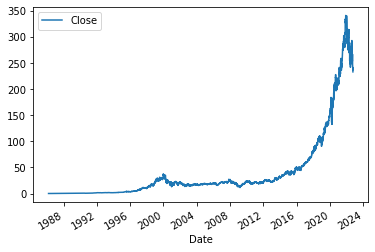

In [11]:
msft_hist.plot.line(y="Close", use_index=True)

Preparing the data
=====
Now, let's prepare the data so we can make predictions. We'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be 1 and if it went down, the target will be 0.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

Then, we'll combine both so we have our training data.

In [13]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {"Close": "Actual_Close"})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [15]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices 
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [16]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [17]:
data.head(5)

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14,0.063158,1.0,0.060980,1.031789e+09,0.055536,0.063703,0.055536
1986-03-17,0.064247,1.0,0.063158,3.081600e+08,0.060980,0.064247,0.060980
1986-03-18,0.062613,0.0,0.064247,1.331712e+08,0.063158,0.064792,0.063158
1986-03-19,0.061524,0.0,0.062613,6.776640e+07,0.064247,0.064792,0.062069
1986-03-20,0.059891,0.0,0.061524,4.789440e+07,0.062613,0.063158,0.060980


Creating a machine learning model
===
Next, let's create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

In [21]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

Next, we'll need to check how accurate the model was. Earlier, we mentioned using precision to measure error. We can do this by using the precision_score function from scikit-learn.

In [25]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.45348837209302323

So our model is directionally accurate 45% of the time. This is alike to a coin flip! We can take a deeper look at the individual predictions and the actuals, and see where we're off.

<AxesSubplot:xlabel='Date'>

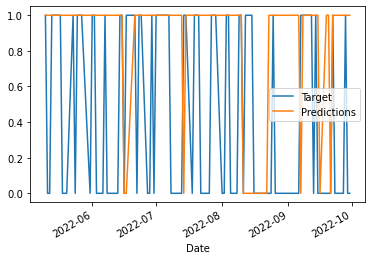

In [28]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

Backtesting
===
Our model isn't great, but luckily we can still improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have has atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

Split the training and test data
Train a model
Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.


In [46]:
start = 1000
step = 750
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    for i in range(start, data.shape[0], step):

        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()

        model.fit(train[predictors], train["Target"])

        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds <= .6] = 0

        combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
        predictions.append(combined)

    predictions = pd.concat(predictions)
    return predictions

In [47]:
predictions["Predictions"].value_counts()

0.0    7516
1.0     697
Name: Predictions, dtype: int64

In [48]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5050215208034433

In [49]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()

weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [50]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [51]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [52]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5657894736842105

In [53]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7620
1.0     228
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

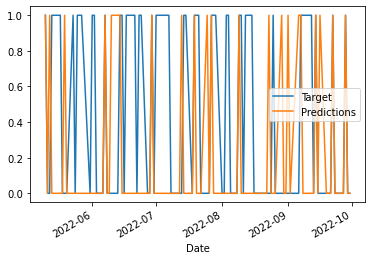

In [54]:
predictions.iloc[-100:].plot()